## Data Balance Analysis using the Adult Census Income dataset

In this example, we will conduct Data Balance Analysis (which consists on running three groups of measures) on the Adult Census Income dataset to determine how well features and feature values are represented in the dataset.

This dataset can be used to predict whether annual income exceeds $50,000/year or not based on demographic data from the 1994 U.S. Census. The dataset we're reading contains 32,561 rows and 14 columns/features.

[More info on the dataset here](https://archive.ics.uci.edu/ml/datasets/Adult)

In [5]:
import sys
sys.path.append('../../notebooks')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from download import download_datasets

In [6]:
data_dir = "../../datasets/"
download_datasets(data_dir)

df = pd.read_csv(data_dir + "AdultCensusIncome.csv", skipinitialspace=True)

label_col = "income"

# convert to 0 and 1 encoding
df[label_col] = df[label_col].apply(lambda x: 0 if x == "<=50K" else 1)

First we can do some preliminary EDA on the data. We will look specifically at a couple columns of interest and see the distribution of how often those feature values show up in the data. 

Text(0.5, 1.02, 'Distribution of Race in the Data')

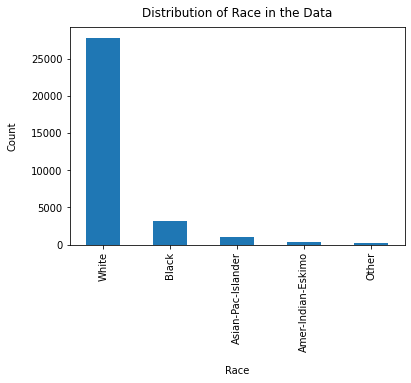

In [7]:
df["race"].value_counts().plot(kind="bar")
plt.xlabel("Race", labelpad=14)
plt.ylabel("Count", labelpad=14)
plt.title("Distribution of Race in the Data", y=1.02)

Text(0.5, 1.02, 'Distribution of Sex in the Data')

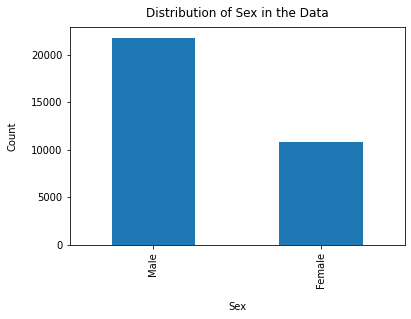

In [8]:
df["sex"].value_counts().plot(kind="bar")
plt.xlabel("Sex", labelpad=14)
plt.ylabel("Count", labelpad=14)
plt.title("Distribution of Sex in the Data", y=1.02)

Text(0.5, 1.02, 'Distribution of Marital Status in the Data')

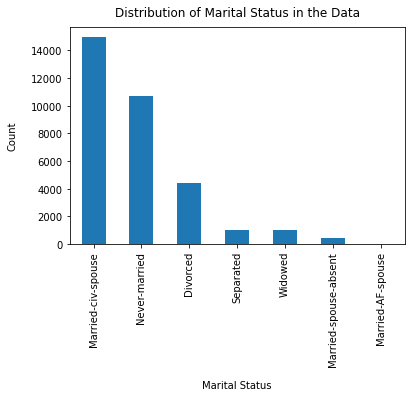

In [9]:
df["marital-status"].value_counts().plot(kind="bar")
plt.xlabel("Marital Status", labelpad=14)
plt.ylabel("Count", labelpad=14)
plt.title("Distribution of Marital Status in the Data", y=1.02)

We will now select a few columns to focus on for this analysis. In this case we will focus specifically on race and sex.

In [10]:
cols_of_interest = ["race", "sex"]

In [11]:
from raimitigations.databalanceanalysis import (
    FeatureBalanceMeasure,
    AggregateBalanceMeasure,
    DistributionBalanceMeasure,
)
feature_measures = FeatureBalanceMeasure(cols_of_interest, label_col)

# drill down to race
feat_measures = feature_measures.measures(df)

In [12]:
feat_measures.head()

,ClassA,ClassB,FeatureName,dp,pmi,sdc,ji,krc,llr,t_test,ttest_pvalue
0,White,Black,race,0.131980,0.725320,0.164302,0.212784,-5.412507,2.911817,-1.354903,0.123458
1,White,Asian-Pac-Islander,race,-0.009780,-0.037512,0.168515,0.217291,-8.742759,3.249841,-2.582092,0.030596
2,White,Amer-Indian-Eskimo,race,0.140104,0.793149,0.195180,0.244934,-14.433135,5.286723,-4.895847,0.004034
3,White,Other,race,0.163609,1.020118,0.196514,0.246278,-15.322864,5.651366,-5.256855,0.003134
4,Black,Asian-Pac-Islander,race,-0.141760,-0.762832,0.004213,0.004507,-3.330252,0.338024,-1.227189,0.143519


We will visualize the demographic parities using a heat map to see which pairs of values have the biggest differences in their label values


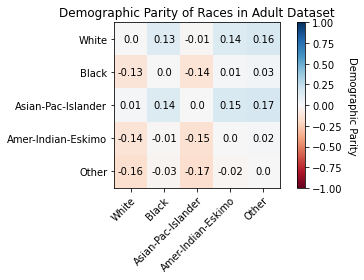

In [13]:
races = df["race"].unique()
race_dp_values = feat_measures[feat_measures["FeatureName"] == "race"][
    ["ClassA", "ClassB", "dp"]
]
race_dp_array = np.zeros((len(races), len(races)))

for idx, row in race_dp_values.iterrows():
    class_a = row[0]
    class_b = row[1]
    dp_value = row[2]
    i, j = np.where(races == class_a)[0][0], np.where(races == class_b)
    dp_value = round(dp_value, 2)
    race_dp_array[i, j] = dp_value
    race_dp_array[j, i] = -1 * dp_value

colormap = "RdBu"
dp_min, dp_max = -1.0, 1.0

fig, ax = plt.subplots()
im = ax.imshow(race_dp_array, vmin=dp_min, vmax=dp_max, cmap=colormap)

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Demographic Parity", rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(races)))
ax.set_yticks(np.arange(len(races)))
ax.set_xticklabels(races)
ax.set_yticklabels(races)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for i in range(len(races)):
    for j in range(len(races)):
        text = ax.text(j, i, race_dp_array[i, j], ha="center", va="center", color="k")

ax.set_title("Demographic Parity of Races in Adult Dataset")
fig.tight_layout()
plt.show()

Next we will look at the Distribution Measures, these measures allow us to compare our data to a reference distribution like the uniform distribution and are calculated based on each specified sensitive column. You don't need the label column to calculate these measures

In [14]:
dist_measures = DistributionBalanceMeasure(cols_of_interest).measures(df)

race_measures = dist_measures[dist_measures["FeatureName"] == "race"].iloc[0]
sex_measures = dist_measures[dist_measures["FeatureName"] == "sex"].iloc[0]

In [15]:
race_measures

FeatureName                     race
kl_divergence               1.055793
js_dist                       0.5104
wasserstein_dist            0.261709
inf_norm_dist               0.654274
total_variation_dist        0.654274
chi_sq_p_value                   0.0
chi_sq_stat             87941.889193
Name: 0, dtype: object

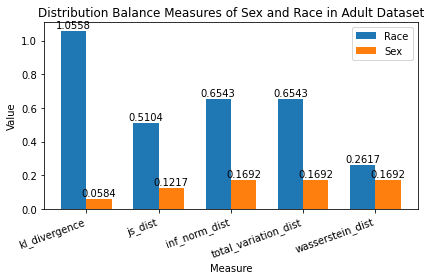

In [16]:
# measures_of_interest = ["kl_divergence", "js_dist", "inf_norm_dist", "total_variation_dist", "wasserstein_dist"]
measures_of_interest =  [
    "kl_divergence",
    "js_dist",
    "inf_norm_dist",
    "total_variation_dist",
    "wasserstein_dist",
]
race_array = [round(race_measures[measure], 4) for measure in measures_of_interest]
sex_array = [round(sex_measures[measure], 4) for measure in measures_of_interest]

x = np.arange(len(measures_of_interest))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width / 2, race_array, width, label="Race")
rects2 = ax.bar(x + width / 2, sex_array, width, label="Sex")

ax.set_xlabel("Measure")
ax.set_ylabel("Value")
ax.set_title("Distribution Balance Measures of Sex and Race in Adult Dataset")
ax.set_xticks(x)
ax.set_xticklabels(measures_of_interest)
ax.legend()

plt.setp(ax.get_xticklabels(), rotation=20, ha="right", rotation_mode="default")


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            "{}".format(height),
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 1),  # 1 point vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom",
        )


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

Interpret Distribution Balance Measures​
Race has a JS Distance of 0.5104 while Sex has a JS Distance of 0.1217.

Knowing that JS Distance is between [0, 1] where 0 means perfectly balanced distribution, we can tell that:

There is a larger disparity between various races than various sexes in our dataset.
Race is nowhere close to a perfectly balanced distribution (i.e. some races are seen ALOT more than others in our dataset).
Sex is fairly close to a perfectly balanced distribution.

Calculate Aggregate Balance Measures​
Aggregate Balance Measures allow us to obtain a higher notion of inequality. They are calculated on the global set of sensitive columns and don't use the label column.

These measures look at distribution of records across all combinations of sensitive columns. For example, if Sex and Race are sensitive columns, it shall try to quantify imbalance across all combinations - (Male, Black), (Female, White), (Male, Asian-Pac-Islander), etc.

In [17]:
agg_measures = AggregateBalanceMeasure(cols_of_interest)
agg_measures.measures(df)

,theil_l_index,theil_t_index,atkinson_index
0,1.50467,1.120823,0.777909


## Summary​
Throughout the course of this sample notebook, we have:

- Chosen "Race" and "Sex" as columns of interest in the Adult Census Income dataset.
- Done preliminary analysis on our dataset.
- Ran the 3 groups of measures that compose our Data Balance 

## Analysis:

- ### Feature Balance Measures
    - Calculated Feature Balance Measures to see that the highest Demographic Parity is in "Sex": Males see >50k income much more than Females.

    - Visualized Demographic Parity of Races to see that Asian-Pac-Islander sees >50k income much more than Other, in addition to other race combinations.

- ### Distribution Balance Measures
    - Calculated Distribution Balance Measures to see that "Sex" is much closer to a perfectly balanced distribution than "Race".
Visualized various distribution balance measures to compare their values for "Race" and "Sex".

- ### Aggregate Balance Measures
    - Calculated Aggregate Balance Measures to see that we need to forego 77.79% of data points to have a perfectly balanced dataset. We identified that our dataset is leaning towards maximum inequality, and we should take actionable steps to:
    - Upsample data points where the feature value is barely observed.
    - Downsample data points where the feature value is observed much more than others.

### In conclusion:

- These measures provide an indicator of disparity on the data, allowing for users to explore potential mitigations before proceeding to train.
- Users can use these measures to set thresholds on their level of "tolerance" for data representation.
Production pipelines can use these measures as baseline for models that require frequent retraining on new data.
- These measures can also be saved as key metadata for the model/service built and added as part of model cards or transparency notes helping drive overall accountability for the ML service built and its performance across different demographics or sensitive attributes.